# Transmission spectrum of HATS-46 b

In this notebook, we perform end-to-end analysis of a transmission spectrum for HATS-46 b using `gallifrey` for stellar background modelling. We will show how use `gallifrey` models for multiple different datasets, how we can use the resulting predictive distributions to sample all 82 transit parameter together in one go! As in previous tutorials, we will use `jaxoplanet` to model the transit signal, and `blackjax` for sampling.

## Notebook setup

In [21]:
import multiprocessing
import os

os.environ["XLA_FLAGS"] = (
    f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
)

In [1]:
# import libraries
import pathlib
import pickle
from collections import OrderedDict

import blackjax
import jax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from astropy.table import Table
from blackjax.util import run_inference_algorithm
from jax import numpy as jnp
from jax import random as jr
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits.keplerian import Body, Central, System
from tqdm import tqdm

from gallifrey import GPConfig, GPModel, LinearSchedule
from gallifrey.kernels import (
    LinearAtom,
    Matern12Atom,
    Matern32Atom,
    Matern52Atom,
    ProductOperator,
    RBFAtom,
    SumOperator,
)

gallifrey: Setting flag `JAX_ENABLE_X64` to `True`
gallifrey: Setting flag `OMP_NUM_THREADS` to `1`


In [2]:
# notebook settings

# making the plots pretty
sns.set_theme(
    context="poster",
    style="ticks",
    palette="rocket",
    font_scale=1,
    rc={
        "figure.figsize": (16, 7),
        "axes.grid": False,
        "font.family": "serif",
        "text.usetex": True,
        "lines.linewidth": 5,
        # "axes.grid": True,
    },
)

# setting saving defaults
save_figures = True
load_models = True  # load pre-trained models
save_models = False  # save trained models, only works if load_models is False

# set saving paths
path = pathlib.Path.cwd().parent
figure_directory = path / "figures/HATS46b/"
if not figure_directory.exists():
    figure_directory.mkdir(parents=True)

# set a random key for for this notebook
rng_key = jr.PRNGKey(7)

## Data preparation

For this tutorial, we will use the pre-processed transmission light curves, which can be found <a href="https://cdsarc.cds.unistra.fr/viz-bin/cat/J/MNRAS/521/5636">here</a>. For more information, please see the original publication by Ahrer+2023 (<a href="https://ui.adsabs.harvard.edu/abs/arXiv:2303.07381">ADS link</a>). We will fix the period of the planet to the value given in the paper.

In [3]:
# load data
data = (
    Table.read(path / "data/HATS46b/HATS_46b.fits")
    .to_pandas()
    .drop(columns=["FWB20", "e_FWB20"])  # not used in paper
    .rename(columns={"Time": "Time [MJD]"})
)

time = jnp.array(data["Time [MJD]"].values)
time_zero = time[0]
time -= time_zero

# spectroscopic and white light curves, initial entry is white lc
flux = jnp.array(data.iloc[:, 1::2].values).T
e_flux = jnp.array(data.iloc[:, 2::2].values).T  # uncertainties

# mask out transit
transit_mask = jnp.where(
    (time > time[6]) & (time < time[41]),
    True,
    False,
)


# reference parameter from arXiv:2303.07381, first entry is white lc
# from arXiv:2303.07381
reference = pd.read_csv(path / "data/HATS46b/HATS_46b_reference.csv").set_index(
    data.columns[1::2]
)
PLANET_PERIOD = 4.7423749  # in days, reference from arXiv:2303.07381

num_datasets = len(flux)
data.head()

,Time [MJD],FWL,e_FWL,FWB01,e_FWB01,FWB02,e_FWB02,FWB03,e_FWB03,FWB04,...,FWB22,e_FWB22,FWB23,e_FWB23,FWB24,e_FWB24,FWB25,e_FWB25,FWB26,e_FWB26
0,57983.131980,1.001562,0.000208,0.998636,0.001034,1.000043,0.000969,1.000023,0.000808,0.999887,...,1.000623,0.001502,0.997391,0.001697,1.002182,0.001811,1.002301,0.001960,1.001256,0.002255
1,57983.135012,1.000602,0.000207,0.997627,0.001031,0.999776,0.000967,0.999022,0.000806,1.001258,...,1.000310,0.001491,0.998996,0.001691,1.000000,0.001792,0.999717,0.001968,0.997278,0.002181
2,57983.138045,1.000448,0.000207,0.997814,0.001027,0.998698,0.000964,0.999182,0.000805,1.000254,...,1.000477,0.001490,1.002012,0.001692,0.999031,0.001790,0.988152,0.001936,1.001592,0.002178
3,57983.141078,1.000778,0.000207,0.999512,0.001024,0.999664,0.000962,0.999969,0.000803,1.000919,...,0.994235,0.001483,1.005648,0.001720,0.997607,0.001758,0.997192,0.001962,0.999897,0.002174
4,57983.144109,1.001500,0.000207,0.998298,0.001021,1.000616,0.000961,1.002659,0.000804,1.000844,...,0.997525,0.001487,1.001105,0.001693,0.997700,0.001789,1.000176,0.001971,0.997816,0.002174


Let's again plot the light curve and our selected transit, to see if everything went right so far. We will only plot the white light curve for now:

Text(0, 0.5, 'Normalized Flux')

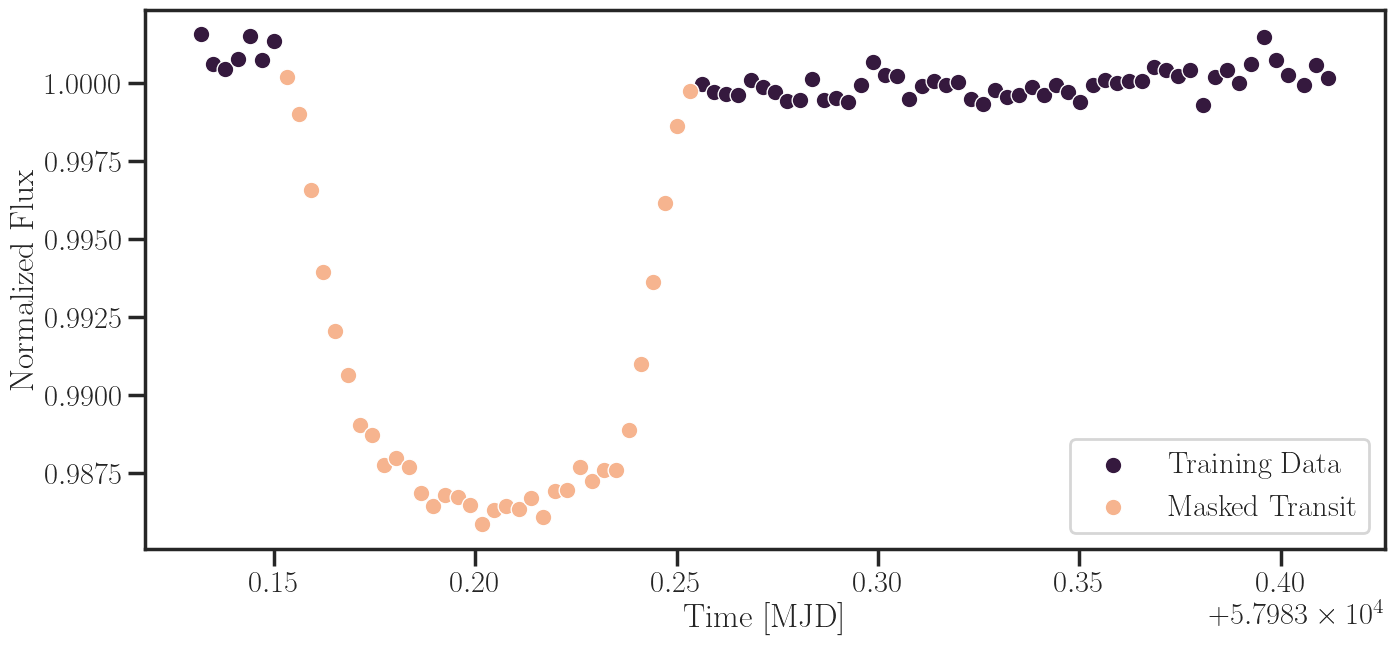

In [4]:
white_lightcurve_plot = sns.scatterplot(
    x=time[~transit_mask] + time_zero,
    y=flux[0, ~transit_mask],
    label="Training Data",
    color="C0",
)
white_lightcurve_plot = sns.scatterplot(
    x=time[transit_mask] + time_zero,
    y=flux[0, transit_mask],
    label="Masked Transit",
    color="C5",
)
white_lightcurve_plot.set_xlabel("Time [MJD]")
white_lightcurve_plot.set_ylabel("Normalized Flux")

# if save_figures:
#     plt.savefig(figure_directory / "white_lightcurve_plot.pdf", bbox_inches="tight")

## `gallifrey` GP models

We will use a seperate GP model for every light curve, but use the same config for all of them.

In [5]:
config = GPConfig(
    max_depth=2,
    atoms=[LinearAtom(), RBFAtom(), Matern12Atom(), Matern32Atom(), Matern52Atom()],
    operators=[SumOperator(), ProductOperator()],
    node_probabilities=jnp.array([1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5]),
)

In [6]:
# create GP models
gpmodels = []
key = rng_key
for i in range(num_datasets):
    key, model_key = jr.split(key)
    gpmodel = GPModel(
        model_key,
        x=time[~transit_mask],
        y=flux[i, ~transit_mask],
        num_particles=8,
        config=config,
    )
    gpmodels.append(gpmodel)

And now we fit the models using the SMC sampler, one after another:

In [7]:
# run the models
model_names = data.columns[1::2]

for i in tqdm(range(num_datasets)):
    gpmodel = gpmodels[i]
    if load_models is False:
        key, smc_key = jr.split(key)
        final_smc_state, history = gpmodel.fit_smc(
            smc_key,
            annealing_schedule=LinearSchedule().generate(len(gpmodel.x), 10),
            n_mcmc=75,
            n_hmc=10,
            verbosity=0,
        )
        if save_models:
            gpmodel.save_state(
                str(
                    path / f"model_checkpoints/HATS46b/final_state_{model_names[i]}.pkl"
                ),
                final_smc_state,
            )
            gpmodel.save_state(
                str(path / f"model_checkpoints/HATS46b/history_{model_names[i]}.pkl"),
                history,
            )
    else:
        final_smc_state = gpmodel.load_state(
            str(path / f"model_checkpoints/HATS46b/final_state_{model_names[i]}.pkl")
        )

    # update the model with the new state
    gpmodels[i] = gpmodel.update_state(final_smc_state)

  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:00<00:00, 39.71it/s]


## Creating the transit model

We have the option to either fit the parameter for each light curve independently, or all within the same model. A common approach is to first fit the shared parameter for the white light curve, and then use these fixed parameter to fit the transit depth (and limb darkening coefficients) for the spectroscopic light curves. This is needed to keep the transmission spectrum consistent (otherwise you might fit different stellar radii for the spectrosopic light curves, which will result in shifted transit depths). But this might lead to overconfident results, since we do not take uncertainties in the shared parameters into account.

Instead, we will use a different approach and sample all parameters together. In this way, we can keep the shared parameters consistent between the different lightcurves, but sample those parameters at the same time. This is typically not done, since one would fit the GP parameters together with the transit parameter leading to large parameter spaces, and very expensive likelihood evaluations. But since we use the GP predictive distributions from `gallifrey` as the background model, we don't have to sample the GP parameters, which makes shared transit parameter sampling feasible.

In [8]:
def transit_model(params, shared_params, time, period):
    # define planetary system model with shared and individual parameters
    central_body = Central(
        mass=shared_params["central_mass"],
        radius=shared_params["central_radius"],
    )

    orbiting_planet = Body(
        period=period,
        radius=params["radius_ratio"] * shared_params["central_radius"],
        inclination=shared_params["inclination"],
        time_transit=shared_params["t0"],
    )

    stellar_system = System(central_body, bodies=[orbiting_planet])

    # return the light curve
    return limb_dark_light_curve(
        stellar_system, jnp.array([params["u1"], params["u2"]])
    )(time).squeeze()


# vectorize the transit model for all datasets
transit_model = jax.vmap(transit_model, in_axes=(0, None, None, None))

## Sampling the transit parameter posterior

We define a single objective over all light curves together. We also define simple flat priors over parameter, similar to the example in the **Comparison with simple kernel** tutorial. This time however, we use _bijectors_ to enforce the parameters to lie between the minimum and maximum allowed values. Bijectors are accomplish this by using parameter transformations. For example, if we want to enforce that a parameter is positive, we can use the `exp` function, since it guarantees the resulting value is larger than zero. Bijectors are used extensively in the internal workings of `gallifrey` to ensure stable sampling. 

We use the bijectors that are implemented in`tensorflow_probability`. Specifically,the `Sigmoid` bijector can be used to ensure that a value is restricted to a specific interval, and the `Softplus` bijector guarantees a parameter to be positive. We will use the `Sigmoid` bijector ro restrict values to lie within plausible ranges given by the original paper.

Finally, unlike in the other tutorials, we won't calculate the probabilities for the entire light curve, but only within the transit region itself. That reduces the number of data points by a good fraction, which should speed up the sampling

In [9]:
from tensorflow_probability.substrates.jax.bijectors import Sigmoid

# define bijectors for the parameters
bijectors = {
    "radius_ratio": Sigmoid(low=0.0, high=1.0),
    "u1": Sigmoid(low=0.3, high=1.0),
    "u2": Sigmoid(low=-0.1, high=0.2),
    "central_mass": Sigmoid(low=0.8, high=0.9),
    "central_radius": Sigmoid(low=0.85, high=0.95),
    "inclination": Sigmoid(low=jnp.deg2rad(80.0), high=jnp.deg2rad(90.0)),
    "t0": Sigmoid(low=0.05, high=0.09),
}


# define a function to transform the parameters using the bijectors
def transform_params(params, bijectors, direction="forward"):
    shared_params_dict = params["shared"]
    individual_params_dict = params["individual"]

    if direction == "forward":
        bijection_funcs = {key: bijectors[key].forward for key in bijectors.keys()}
    elif direction == "inverse":
        bijection_funcs = {key: bijectors[key].inverse for key in bijectors.keys()}

    shared_params = OrderedDict(
        {key: bijection_funcs[key](value) for key, value in shared_params_dict.items()}
    )
    individual_params = OrderedDict(
        {
            key: bijection_funcs[key](value)
            for key, value in individual_params_dict.items()
        }
    )
    return OrderedDict({"shared": shared_params, "individual": individual_params})

In [10]:
time_norm = gpmodels[0].x_transform(time)  # same for all models
time_transit = time_norm[transit_mask]

# create predictive distributions for each dataset (only for the transit region)
predictive_gmms = [
    gpmodel.get_mixture_distribution(time_transit) for gpmodel in gpmodels
]

In [11]:
def objective(params, time, flux, predictive_gmms, gpmodels, bijectors):

    # transform the parameters to the original space
    constrained_params = transform_params(params, bijectors, direction="forward")

    # calculate the transit light curves and residuals
    transit_light_curves = transit_model(
        constrained_params["individual"],
        constrained_params["shared"],
        time,
        PLANET_PERIOD,
    )

    residuals = flux - transit_light_curves

    # calculate the log probability for each light curve
    log_probs = jnp.array(
        [
            predictive_gmm.log_prob(gpmodel.y_transform(residual))
            for residual, gpmodel, predictive_gmm in zip(
                residuals, gpmodels, predictive_gmms
            )
        ]
    )
    # sum the log probabilities to get the total log probability
    log_prob = jnp.sum(log_probs)
    return log_prob

We use the just-in-time compilation feature of jax to speed up the objective evaluations, and only pass time and flux values for the transit region to the objective.

In [12]:
jitted_objective = jax.jit(
    lambda params: objective(
        params,
        time[transit_mask],
        flux[:, transit_mask],
        predictive_gmms,
        gpmodels,
        bijectors,
    )
)

And define an initial guess for the transit parameters, we'll use values from the original paper.

In [13]:
initial_shared_params = OrderedDict(
    central_mass=jnp.array(0.869),
    central_radius=jnp.array(0.894),
    inclination=jnp.deg2rad(86.97),
    t0=jnp.array(0.07527),
)

initial_individual_params = OrderedDict(
    radius_ratio=jnp.full(num_datasets, 0.1125),
    u1=jnp.full(num_datasets, 0.547),
    u2=jnp.full(num_datasets, 0.1171),
)

initial_params = OrderedDict(
    shared=initial_shared_params,
    individual=initial_individual_params,
)

# transform parameters to unconstrained space
initial_params_uncontrained = transform_params(
    initial_params, bijectors, direction="inverse"
)

Finally, we can sample the posterior using the `NUTS` sampler from `blackjax`. This will be quite computationally expensive (we're sampling 82 parameters after all!), so we use `jax.pmap` to parallelise the inference algorithm function, and sample 8 chains at once.

In [14]:
if load_models is False:
    # parameter adaption and burn-in
    warmup = blackjax.window_adaptation(
        blackjax.nuts, jitted_objective, progress_bar=True
    )
    key, warmup_key, sample_key = jax.random.split(key, 3)
    (burned_in_state, nuts_parameters), _ = warmup.run(
        warmup_key,
        initial_params_uncontrained,
        num_steps=1000,
    )

    # sampling
    nuts_sampler = blackjax.nuts(jitted_objective, **nuts_parameters)
    inference_algorithm = lambda rng_key: run_inference_algorithm(
        rng_key=rng_key,
        inference_algorithm=nuts_sampler,
        num_steps=int(3e3),
        initial_state=burned_in_state,
        progress_bar=True,
    )
    final_state, (history, info) = jax.pmap(inference_algorithm)(
        jr.split(sample_key, 8)
    )

    # transform the parameters back to the original space
    mcmc_chains = transform_params(history.position, bijectors, direction="forward")

    if save_models:
        with open(path / "data/interim/mcmc_chains/HATS46b.pkl", "wb") as file:
            pickle.dump(mcmc_chains, file)
else:
    with open(path / "data/interim/mcmc_chains/HATS46b.pkl", "rb") as file:
        mcmc_chains = pickle.load(file)

We can flatten the 8 seperate MCMC chains into single chains:

In [15]:
mcmc_chains["shared"] = {
    key: value.reshape(-1) for key, value in mcmc_chains["shared"].items()
}
mcmc_chains["individual"] = {
    key: value.reshape(-1, num_datasets)
    for key, value in mcmc_chains["individual"].items()
}

## Plotting the transmission spectrum

With the chains we obtained, we can finally plot the transmission spectrum. Let's also plot the reference spectrum from the original paper for comparison.

In [16]:
# get the chains for the radius ratio, and flatten them for the different walkers
radius_ratio = mcmc_chains["individual"]["radius_ratio"]

# calculate the percentiles
r_median = jnp.median(radius_ratio, axis=0)
r_low = jnp.percentile(radius_ratio, 16, axis=0)
r_high = jnp.percentile(radius_ratio, 84, axis=0)

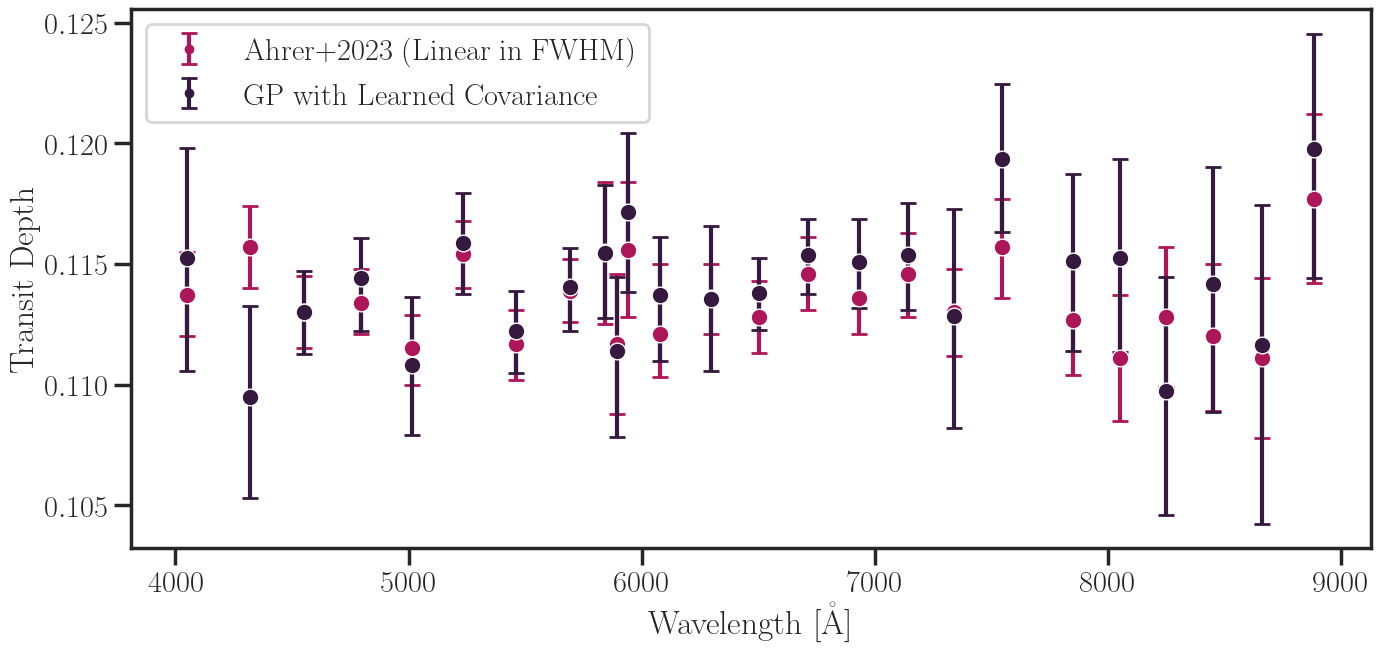

In [17]:
def plot_spectrum(radius_ratio_median, ylabel):
    fig, ax = plt.subplots()

    # we skip the first entry as it is the white light curve
    for data, errors, label, color in zip(
        [reference["Rp"][1:], radius_ratio_median],
        [
            reference[["e_Rp_lower", "e_Rp_upper"]][1:],
            jnp.stack([r_median[1:] - r_low[1:], r_high[1:] - r_median[1:]]).T,
        ],
        ["Ahrer+2023 (Linear in FWHM)", "GP with Learned Covariance"],
        ["C2", "C0"],
    ):

        ax.errorbar(
            reference["wavelength"].iloc[1:],
            data,
            yerr=errors.T,
            fmt=".",
            capsize=6,
            capthick=2,
            elinewidth=3,
            color=color,
            label=label,
        )
        sns.scatterplot(
            x=reference["wavelength"].iloc[1:],
            y=data,
            color=color,
            zorder=10,
            ax=ax,
        )

    ax.legend()
    ax.set_xlabel(r"Wavelength [$\mathrm{\mathring{A}}$]")
    ax.set_ylabel(ylabel)
    return fig


fig = plot_spectrum(r_median[1:], "Transit Depth")
if save_figures:
    plt.savefig(figure_directory / "transmission_spectrum.pdf", bbox_inches="tight")

## Plotting the light curves

We can also plot the light curves themselves, to see if our model yields a good representation of the data. To stay fully in the Bayesian framework, we should sample light curves from the joint distribution of the Gaussian Processes and transit light curves. For this notebook, we'll make our lives a little easier and simply use the Gaussian process means, and median transit parameters. (In particular that means we only take the Gaussian Process variance into account here, not the transit parameter uncertainties.)

In [18]:
# get GP means and stddevs from predictive distributions (this time for the whole light curve)
gp_gmms = [gpmodel.get_mixture_distribution(time_norm) for gpmodel in gpmodels]
gp_means = jnp.array([gp_gmm.mean() for gp_gmm in gp_gmms])
gp_stds = jnp.array([gp_gmm.stddev() for gp_gmm in gp_gmms])

# get mean transit parameters
shared_transit_parameter_means = {
    key: jnp.median(value) for key, value in mcmc_chains["shared"].items()
}
individual_transit_parameter_means = {
    key: jnp.median(value, axis=0) for key, value in mcmc_chains["individual"].items()
}
transit_parameter_means = {
    "shared": shared_transit_parameter_means,
    "individual": individual_transit_parameter_means,
}

# calculate mean transit light curves
transit_light_curves = transit_model(
    transit_parameter_means["individual"],
    transit_parameter_means["shared"],
    time,
    PLANET_PERIOD,
)

Now we can calculate the full model light curves (GP + transit) and the residuals. We'll put them all in a dataframe for easier plotting.

In [19]:
light_curve_models = []

for i in range(1, num_datasets):  # skip the white light curve
    gp_mean = gpmodels[i].y_transform.unapply(gp_means[i])
    light_curve = gp_mean + transit_light_curves[i]

    df_data = {"Time [MJD]": time + time_zero, "Flux": light_curve}

    # calculate 1, 2, and 3 sigma
    for sig in [1, 2, 3]:
        gp_lower = gpmodels[i].y_transform.unapply(gp_means[i] - sig * gp_stds[i])
        gp_upper = gpmodels[i].y_transform.unapply(gp_means[i] + sig * gp_stds[i])

        df_data[f"lower_{sig}sig"] = gp_lower + transit_light_curves[i]
        df_data[f"upper_{sig}sig"] = gp_upper + transit_light_curves[i]

    df_data[r"$\lambda$"] = (
        str(reference["wavelength"].iloc[i]) + r"$\mathrm{\mathring{A}}$"
    )

    df = pd.DataFrame(df_data)

    light_curve_models.append(df)

light_curve_models = pd.concat(light_curve_models)

And finally we plot all the different light curves:

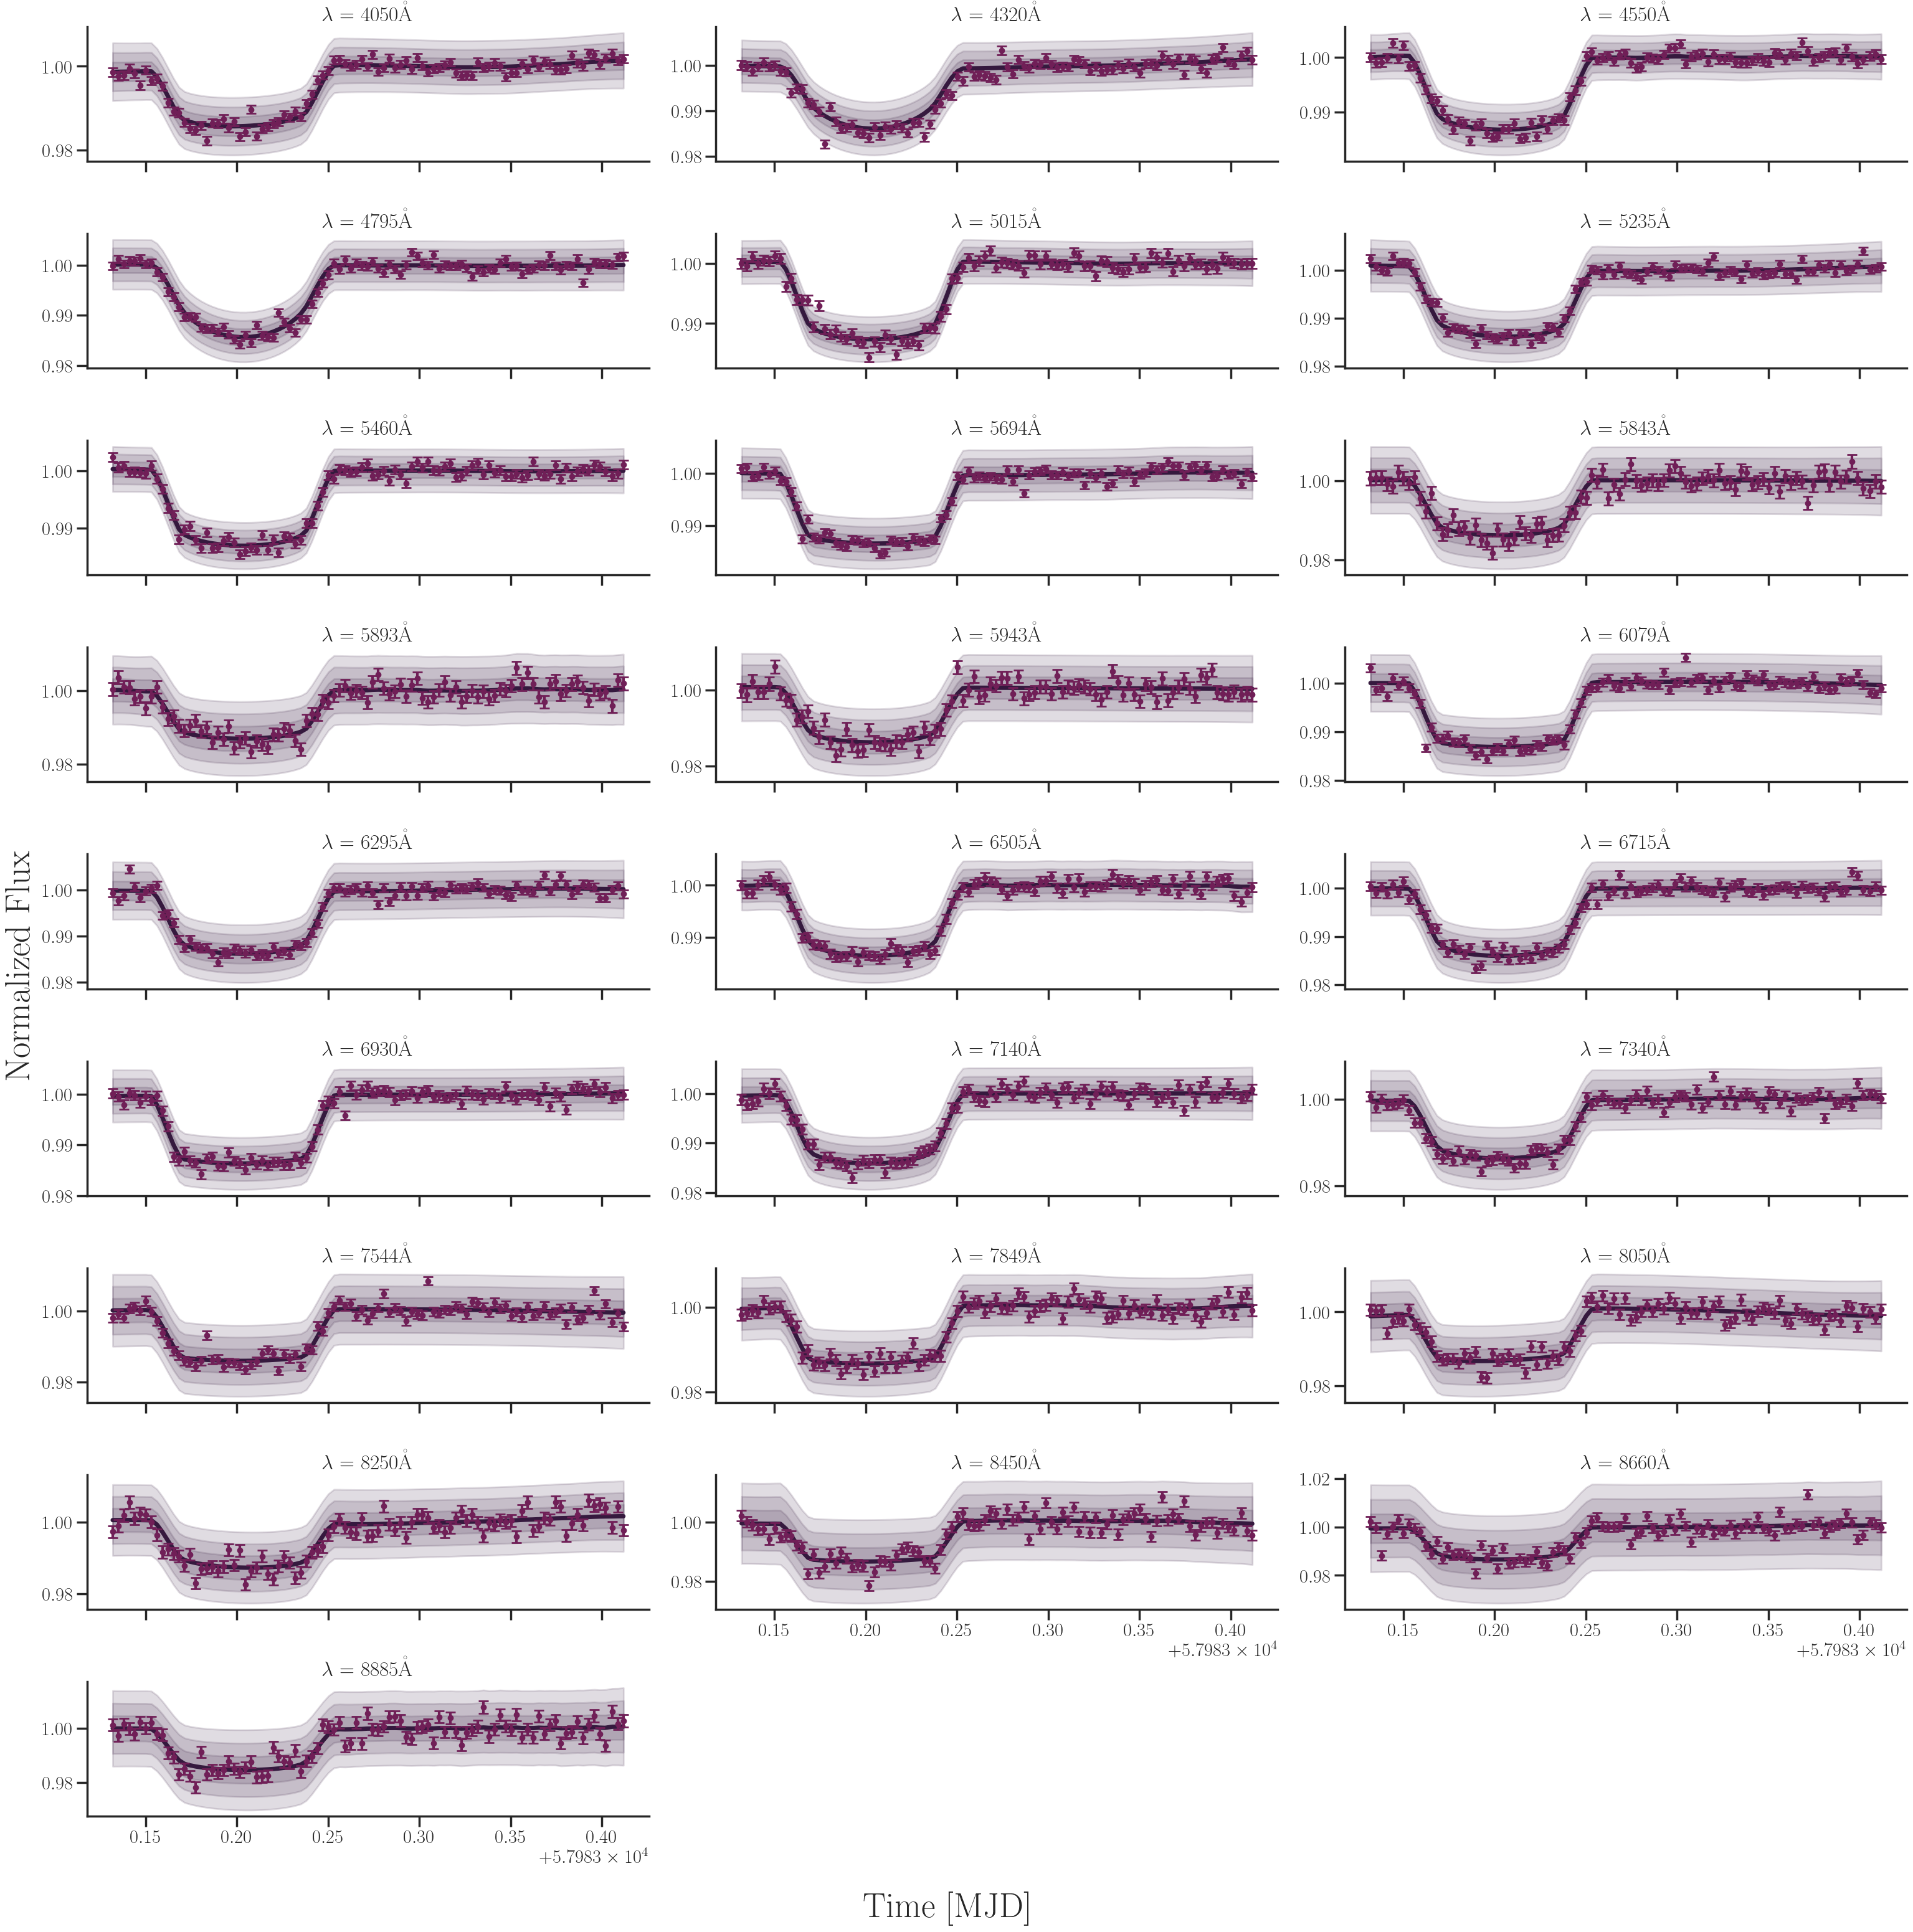

In [20]:
light_curve_plot = sns.FacetGrid(
    light_curve_models,
    col=r"$\lambda$",
    col_wrap=3,
    sharex=True,
    sharey=False,
    height=3.5,
    aspect=3,
)

light_curve_plot.map(sns.lineplot, "Time [MJD]", "Flux", color="C0")

for sig in [1, 2, 3]:
    light_curve_plot.map(
        plt.fill_between,
        "Time [MJD]",
        f"lower_{sig}sig",
        f"upper_{sig}sig",
        alpha=0.15,
        color="C0",
    )

for i, ax in enumerate(light_curve_plot.axes):
    ax.errorbar(
        time + time_zero,
        flux[i + 1],
        yerr=e_flux[i + 1],
        fmt=".",
        capsize=6,
        capthick=2,
        elinewidth=3,
        color="C1",
    )

light_curve_plot.set_axis_labels("", "")

light_curve_plot.figure.supxlabel("Time [MJD]", fontsize=40)
light_curve_plot.figure.supylabel("Normalized Flux", fontsize=40)
light_curve_plot.figure.tight_layout()

if save_figures:
    plt.savefig(figure_directory / "light_curve_models.pdf", bbox_inches="tight")